In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [2]:
import sys
import os
root_dir = "/gdrive/MyDrive/NLP/week12/12-2. Pretrained LM2"
sys.path.append(root_dir)

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.6 MB/s eta 0:00:00


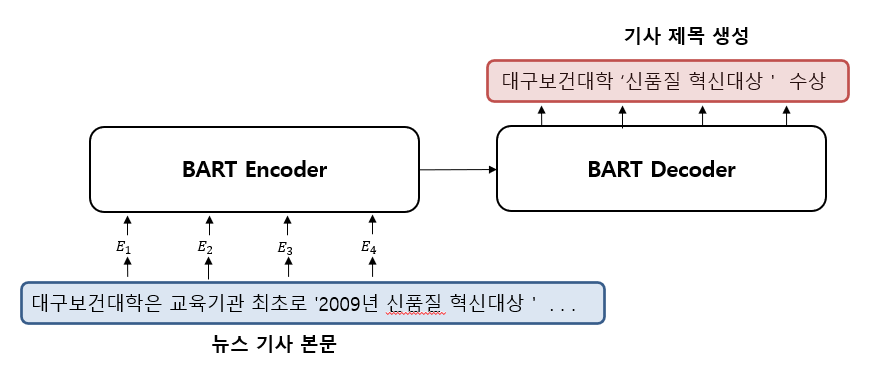

In [4]:
from IPython.display import Image
Image(os.path.join(root_dir, "TitleGeneration.PNG"))

In [5]:
import logging

import os
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, RandomSampler
from transformers import AdamW
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

def read_data(file_path):
    datas = []
    with open(file_path, "r", encoding="utf8") as infile:
        for line in infile:
          # 입력 데이터를 \t을 기준으로 분리
          pieces = line.strip().split("\t")
          article, title = pieces[0], pieces[1]
          datas.append((article, title))

    return datas


def convert_data2feature(datas, max_length, max_dec_length, tokenizer):
    input_ids_features, attention_mask_features, decoder_input_features, decoder_attention_mask_features, label_features = [], [], [], [], []

    for article, title in tqdm(datas, desc="convert_data2feature"):
        # tokenizer를 사용하여 입력 문장을 word piece 단위로 분리
        tokenized_article = tokenizer.tokenize(article)
        tokenized_title= tokenizer.tokenize(title)

        #########################################
        
        
        input_ids = tokenizer.convert_tokens_to_ids(tokenized_article)
        attention_mask = [1] * len(input_ids)

        decoder_input = tokenizer.convert_tokens_to_ids(['<s>'] + tokenized_title)
        decoder_attention_mask = [1] * len(decoder_input)
        label = tokenizer.convert_tokens_to_ids(tokenized_title + ['</s>'])

        #########################################


        # 변환한 데이터를 각 리스트에 저장
        input_ids_features.append(input_ids[:max_length] + [0]*(max_length - len(input_ids)))
        attention_mask_features.append(attention_mask[:max_length] + [0]*(max_length - len(attention_mask)))
        decoder_input_features.append(decoder_input[:max_dec_length] + [0]*(max_dec_length - len(decoder_input)))
        decoder_attention_mask_features.append(decoder_attention_mask[:max_dec_length] + [0]*(max_dec_length-len(decoder_attention_mask)))
        label_features.append(label[:max_dec_length] + [0]*(max_dec_length - len(label)))

    # 변환한 데이터를 Tensor 객체에 담아 반환
    input_ids_features = torch.tensor(input_ids_features, dtype=torch.long)
    attention_mask_features = torch.tensor(attention_mask_features, dtype=torch.long)
    decoder_input_features = torch.tensor(decoder_input_features, dtype=torch.long)
    decoder_attention_mask_features = torch.tensor(decoder_attention_mask_features, dtype=torch.long)
    label_features = torch.tensor(label_features, dtype=torch.long)

    return input_ids_features, attention_mask_features, decoder_input_features, decoder_attention_mask_features, label_features

def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [6]:
logger = logging.getLogger(__name__)
from torch.utils.data import (DataLoader, TensorDataset, RandomSampler, SequentialSampler)
from transformers import BartForConditionalGeneration
from transformers import PreTrainedTokenizerFast
def train(config):
    tokenizer = PreTrainedTokenizerFast.from_pretrained(config["pretrained_model_name_or_path"])
    model = BartForConditionalGeneration.from_pretrained(config["pretrained_model_name_or_path"]).cuda()
    """ Train the model """
    # 학습 및 평가 데이터 읽기
    train_datas = read_data(config["train_data_path"])
    test_datas = read_data(config["test_data_path"])

    # 입력 데이터 전처리
    train_input_ids_features, train_attention_mask_features, train_decoder_input_features, train_decoder_attention_mask_features, train_label_features = \
        convert_data2feature(train_datas, config["max_length"],config["max_dec_length"], tokenizer)
    test_input_ids_features, test_attention_mask_features, test_decoder_input_features, test_decoder_attention_mask_features, test_label_features = \
        convert_data2feature(test_datas, config["max_length"], config["max_dec_length"], tokenizer)

    # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    train_features = TensorDataset(train_input_ids_features, train_attention_mask_features, train_decoder_input_features, train_decoder_attention_mask_features, train_label_features)
    train_dataloader = DataLoader(train_features, sampler=RandomSampler(train_features),
                                  batch_size=config["batch_size"])

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_features = TensorDataset(test_input_ids_features, test_attention_mask_features, test_decoder_input_features, test_decoder_attention_mask_features, test_label_features)
    test_dataloader = DataLoader(test_features, sampler=SequentialSampler(test_features),
                                 batch_size=config["batch_size"])

    # 모델 학습을 위한 optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
    global_step = 1

    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()

    set_seed(config["seed"])

    for epoch in range(config["epoch"]):
        for step, batch in enumerate(train_dataloader):
            # Skip past any already trained steps if resuming training
            model.train()
            batch = tuple(t.cuda() for t in batch)
            outputs = model(input_ids=batch[0],
                              attention_mask=batch[1],
                              decoder_input_ids=batch[2],
                              decoder_attention_mask=batch[3],
                              labels=batch[4],
                                return_dict=True)

            loss = outputs["loss"]

            loss.backward()
            if (global_step+1) % 50 == 0:
                print("{} Processed.. Total Loss : {}".format(global_step+1, loss.item()))

            tr_loss += loss.item() # 텐서에서 스칼라 값을 추출하는 방법 

            optimizer.step()
            model.zero_grad()
            global_step += 1

            # Save model checkpoint
            if global_step % 500 == 0:
                evaluate(config, model, tokenizer, test_dataloader)

                output_dir = os.path.join(config["output_dir_path"], "checkpoint-{}".format(global_step))
                print("Model Save in {}".format(output_dir))
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)

                # Take care of distributed/parallel training
                model_to_save = model.module if hasattr(model, "module") else model
                model_to_save.save_pretrained(output_dir)

    return global_step, tr_loss / global_step

def evaluate(config, model, tokenizer, test_dataloader):
    model.eval()
    for batch in tqdm(test_dataloader):
        batch = tuple(t.cuda() for t in batch)

        dec_outputs = model.generate(input_ids = batch[0], # 생성을 위한 별도의 함수 제공
                                     attention_mask=batch[1],
                                     max_length=config["max_dec_length"],
                                     eos_token_id=1, # </s>
                                     do_sample=False, # Greedy search 할 것인지 Sampling할 것인지 여부
                                     bad_words_ids=[[5]] # 나쁜말 생성 금지 
                                    )

        batch_size = batch[0].size()[0]

        dec_outputs = dec_outputs.tolist()
        dec_labels = batch[4].tolist()
      
        # 
        for index in range(batch_size):
            if 1 in dec_outputs[index]: # 처음부터 EOS까지만 끊어오기
                dec_outputs[index] = dec_outputs[index]
            if -100 in dec_labels[index]:
                dec_labels[index] = dec_labels[index][:dec_labels[index].index(-100)] # 처음부터 Padding index까지만 끊어오기
            else:
                dec_labels[index] = dec_labels[index] 
            pred = "".join(tokenizer.convert_ids_to_tokens(dec_outputs[index][1:])).replace("Ġ", " ").replace("<pad>", "").replace("</s>", "").replace("▁", " ")
            ref = "".join(tokenizer.convert_ids_to_tokens(dec_labels[index][:-1])).replace("Ġ", " ").replace("<pad>", "").replace("</s>", "").replace("▁", " ")

            print("REFERENCE : {}\nDECODED   : {}\n".format(ref, pred))

            #  


In [ ]:
if (__name__ == "__main__"):
    save_dir = os.path.join(root_dir, "save")
    output_dir = os.path.join(root_dir, "output")
    cache_dir = os.path.join(root_dir, "cache")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)

    set_seed(seed=1234)

    config = {"mode": "train",
              "train_data_path": os.path.join(root_dir, "train.txt"),
              "test_data_path": os.path.join(root_dir, "test.txt"),
              "output_dir_path": output_dir,
              "save_dir_path": save_dir,
              "cache_dir_path": cache_dir,
              "pretrained_model_name_or_path": "hyunwoongko/kobart",
              "max_length": 250,
              "max_dec_length": 60,
              "epoch": 30,
              "batch_size": 16,
              "seed": 42,
              }

    if (config["mode"] == "train"):
        train(config)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


convert_data2feature: 100%|██████████| 14/14 [00:00<00:00, 714.75it/s]


50 Processed.. Total Loss : 0.6685424447059631
100 Processed.. Total Loss : 0.5815239548683167
150 Processed.. Total Loss : 0.6125548481941223
200 Processed.. Total Loss : 0.6515547037124634
250 Processed.. Total Loss : 0.6401870250701904
300 Processed.. Total Loss : 0.7282831072807312
350 Processed.. Total Loss : 0.5221148133277893
400 Processed.. Total Loss : 0.5216954946517944
450 Processed.. Total Loss : 0.5960654616355896
500 Processed.. Total Loss : 0.698022723197937


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, 페이스북 이벤트 실시

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산 도심 도심광장 조성

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  영어교육교육박람회 14일부터 3일간 엑스코서

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계 요구

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s

550 Processed.. Total Loss : 0.58951735496521
600 Processed.. Total Loss : 0.588764488697052
650 Processed.. Total Loss : 0.5408945083618164
700 Processed.. Total Loss : 0.5907207727432251
750 Processed.. Total Loss : 0.665989875793457
800 Processed.. Total Loss : 0.5211495161056519
850 Processed.. Total Loss : 0.5043225884437561
900 Processed.. Total Loss : 0.4576096534729004
950 Processed.. Total Loss : 0.5534312725067139
1000 Processed.. Total Loss : 0.47524726390838623


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, 페이스북 이벤트 실시

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산 도심광장 생긴다

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  영어교육교육박람회 14일부터 대구 엑스코서 열려

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계키로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>

1050 Processed.. Total Loss : 0.47849395871162415
1100 Processed.. Total Loss : 0.49976205825805664
1150 Processed.. Total Loss : 0.4590243101119995
1200 Processed.. Total Loss : 0.5308474898338318
1250 Processed.. Total Loss : 0.5397474765777588
1300 Processed.. Total Loss : 0.5037034749984741
1350 Processed.. Total Loss : 0.48281624913215637
1400 Processed.. Total Loss : 0.5733191967010498
1450 Processed.. Total Loss : 0.5567854046821594
1500 Processed.. Total Loss : 0.4851575791835785


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, 페이스북 통해 ‘미생(美生)’ 이벤트 진행

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도 광화문광장에 버금가는 대형 도심광장

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  영어교육교육박람회 14일부터 3일간 엑스코서 열려

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 주도 교사 징계키로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><

1550 Processed.. Total Loss : 0.5341697931289673
1600 Processed.. Total Loss : 0.3941645920276642
1650 Processed.. Total Loss : 0.5694546103477478
1700 Processed.. Total Loss : 0.4611520767211914
1750 Processed.. Total Loss : 0.5975858569145203
1800 Processed.. Total Loss : 0.5236141681671143
1850 Processed.. Total Loss : 0.44814643263816833
1900 Processed.. Total Loss : 0.42008039355278015
1950 Processed.. Total Loss : 0.3090486228466034
2000 Processed.. Total Loss : 0.3587222099304199


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(美生)’ 페이스북 이벤트 실시

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산 도심광장 생긴다

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국영어교육박람회 14∼15일 엑스코서 열려

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계 시한 11일로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><

2050 Processed.. Total Loss : 0.3517835736274719
2100 Processed.. Total Loss : 0.28800728917121887
2150 Processed.. Total Loss : 0.3058346211910248
2200 Processed.. Total Loss : 0.3203890919685364
2250 Processed.. Total Loss : 0.3429489731788635
2300 Processed.. Total Loss : 0.3819850981235504
2350 Processed.. Total Loss : 0.37915799021720886
2400 Processed.. Total Loss : 0.34265345335006714
2450 Processed.. Total Loss : 0.3883045017719269
2500 Processed.. Total Loss : 0.4279797673225403


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, 페이스북 이벤트 진행

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산 도심 광화문광장에 버금가는 대형광장 조성

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국영어교육박람회 14∼3일 엑스코서 열려

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 참여 교사 징계키로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>

2550 Processed.. Total Loss : 0.37124189734458923
2600 Processed.. Total Loss : 0.4323931336402893
2650 Processed.. Total Loss : 0.3142002522945404
2700 Processed.. Total Loss : 0.2982332408428192
2750 Processed.. Total Loss : 0.32839587330818176
2800 Processed.. Total Loss : 0.3017999231815338
2850 Processed.. Total Loss : 0.41162869334220886
2900 Processed.. Total Loss : 0.17201228439807892
2950 Processed.. Total Loss : 0.22289174795150757
3000 Processed.. Total Loss : 0.2433929592370987


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, 연말연시 직장인 대상 ‘미생(美生)’ 페이스북 이벤트

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도 광화문광장에 버금가는 대형 도심광장 조성

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국영어교육박람회 14∼15일 엑스코서 열려

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계키로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>

3050 Processed.. Total Loss : 0.25152990221977234
3100 Processed.. Total Loss : 0.34679460525512695
3150 Processed.. Total Loss : 0.22536906599998474
3200 Processed.. Total Loss : 0.290328711271286
3250 Processed.. Total Loss : 0.18821600079536438
3300 Processed.. Total Loss : 0.22842536866664886
3350 Processed.. Total Loss : 0.21303223073482513
3400 Processed.. Total Loss : 0.2911723256111145
3450 Processed.. Total Loss : 0.2017076015472412
3500 Processed.. Total Loss : 0.2507585883140564


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생’ 페이스북 이벤트 진행

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  서울 광화문광장 닮은 대형 도심광장, 부산중앙광장 조성

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국영어교육박람회

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 주도 교사 징계 지시

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>

3550 Processed.. Total Loss : 0.232760950922966
3600 Processed.. Total Loss : 0.26331865787506104
3650 Processed.. Total Loss : 0.28449684381484985
3700 Processed.. Total Loss : 0.2890681028366089
3750 Processed.. Total Loss : 0.2647748589515686
3800 Processed.. Total Loss : 0.28016430139541626
3850 Processed.. Total Loss : 0.2183884084224701
3900 Processed.. Total Loss : 0.17112046480178833
3950 Processed.. Total Loss : 0.1640019565820694
4000 Processed.. Total Loss : 0.18000660836696625


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(美生)’ 페이스북 이벤트

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도 도심광장 생긴다

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국어교육박람회 3일간 엑스코서 열려

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계키로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>

4050 Processed.. Total Loss : 0.11839815229177475
4100 Processed.. Total Loss : 0.1569436937570572
4150 Processed.. Total Loss : 0.27205169200897217
4200 Processed.. Total Loss : 0.13518781960010529
4250 Processed.. Total Loss : 0.15731927752494812
4300 Processed.. Total Loss : 0.18909262120723724
4350 Processed.. Total Loss : 0.26698440313339233
4400 Processed.. Total Loss : 0.18859048187732697
4450 Processed.. Total Loss : 0.1605842262506485
4500 Processed.. Total Loss : 0.1753823310136795


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 페이스북 이벤트 실시

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에 광화문광장에 버금가는 대형 도심광장 만든다

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국어교육박람회 14∼15일 엑스코에서 개최

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교감 징계시한 내로...대구·광주 등 6곳은 ‘미적’

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>

4550 Processed.. Total Loss : 0.18262070417404175
4600 Processed.. Total Loss : 0.17562083899974823
4650 Processed.. Total Loss : 0.13586460053920746
4700 Processed.. Total Loss : 0.17037314176559448
4750 Processed.. Total Loss : 0.18890009820461273
4800 Processed.. Total Loss : 0.2705760896205902
4850 Processed.. Total Loss : 0.09441778808832169
4900 Processed.. Total Loss : 0.07715786248445511
4950 Processed.. Total Loss : 0.16532865166664124
5000 Processed.. Total Loss : 0.09977138042449951


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(美生) 페이스북 이벤트’ 진행

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  광화문광장 본뜬 대형 도심광장, 부산에 들어선다

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국어교육박람회 14일부터 3일간 엑스코서

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 주도 교사 징계키로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s

5050 Processed.. Total Loss : 0.15539740025997162
5100 Processed.. Total Loss : 0.13710752129554749
5150 Processed.. Total Loss : 0.1061154380440712
5200 Processed.. Total Loss : 0.11102590709924698
5250 Processed.. Total Loss : 0.10037393867969513
5300 Processed.. Total Loss : 0.14891880750656128
5350 Processed.. Total Loss : 0.10623954236507416
5400 Processed.. Total Loss : 0.11795835196971893
5450 Processed.. Total Loss : 0.13473457098007202
5500 Processed.. Total Loss : 0.13553018867969513


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(美生) 페이스북 이벤트’ 진행

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도 광화문광장에 버금가는 대형 도심광장 조성

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국영어교육박람회

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계 시한 11일로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>

5550 Processed.. Total Loss : 0.14205607771873474
5600 Processed.. Total Loss : 0.1365276277065277
5650 Processed.. Total Loss : 0.14278922975063324
5700 Processed.. Total Loss : 0.12082365900278091
5750 Processed.. Total Loss : 0.12201432883739471
5800 Processed.. Total Loss : 0.07524905353784561
5850 Processed.. Total Loss : 0.0653640478849411
5900 Processed.. Total Loss : 0.057183582335710526
5950 Processed.. Total Loss : 0.0874699279665947
6000 Processed.. Total Loss : 0.07225607335567474


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, 직장인 위한 ‘미생(美生) 페이스북 이벤트

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도 광화문광장에 이어 대형 도심광장

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국어교육박람회

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 파악해 징계키로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s

6050 Processed.. Total Loss : 0.06925798952579498
6100 Processed.. Total Loss : 0.08269007503986359
6150 Processed.. Total Loss : 0.07824495434761047
6200 Processed.. Total Loss : 0.07797861844301224
6250 Processed.. Total Loss : 0.0777837410569191
6300 Processed.. Total Loss : 0.07508914172649384
6350 Processed.. Total Loss : 0.0825689360499382
6400 Processed.. Total Loss : 0.07057507336139679
6450 Processed.. Total Loss : 0.059949833899736404
6500 Processed.. Total Loss : 0.09006340056657791


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 페이스북 이벤트

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도광장 생긴다

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국어교육박람회

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계키로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><

6550 Processed.. Total Loss : 0.06948862224817276
6600 Processed.. Total Loss : 0.0809297040104866
6650 Processed.. Total Loss : 0.08931851387023926
6700 Processed.. Total Loss : 0.08097270131111145
6750 Processed.. Total Loss : 0.04744122549891472
6800 Processed.. Total Loss : 0.027255607768893242
6850 Processed.. Total Loss : 0.04558541625738144
6900 Processed.. Total Loss : 0.035418760031461716
6950 Processed.. Total Loss : 0.05023055151104927
7000 Processed.. Total Loss : 0.039334289729595184


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 이벤트 진행

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도 광화문광장에 이어 대형 도심광장 추진

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국어교육박람회 14∼3일 대구서 열려

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, ‘역사교과서 국정화 반대’ 시국선언 교사 징계 시한 11일로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s

7050 Processed.. Total Loss : 0.0555858388543129
7100 Processed.. Total Loss : 0.04814811423420906
7150 Processed.. Total Loss : 0.06571745872497559
7200 Processed.. Total Loss : 0.06019501015543938
7250 Processed.. Total Loss : 0.032700661569833755
7300 Processed.. Total Loss : 0.03625130280852318
7350 Processed.. Total Loss : 0.053628914058208466
7400 Processed.. Total Loss : 0.0490187369287014
7450 Processed.. Total Loss : 0.06195775792002678
7500 Processed.. Total Loss : 0.06606490910053253


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(美生) 페이스북 이벤트’ 개최

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산 도심광장 생긴다

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  경제부,12.04/'대한민국영어교육박람회'

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, ‘역사교과서 국정화 반대’ 시국선언 교사 징계키로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>

7550 Processed.. Total Loss : 0.07898783683776855
7600 Processed.. Total Loss : 0.09243340790271759
7650 Processed.. Total Loss : 0.05789332464337349
7700 Processed.. Total Loss : 0.0660654753446579
7750 Processed.. Total Loss : 0.02146906778216362
7800 Processed.. Total Loss : 0.03705012425780296
7850 Processed.. Total Loss : 0.027533523738384247
7900 Processed.. Total Loss : 0.033665597438812256
7950 Processed.. Total Loss : 0.036011405289173126
8000 Processed.. Total Loss : 0.04065096750855446


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(美生)’ 페이스북 이벤트

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도광장 조성한다

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국어교육박람회

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 파악 나선다

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>

8050 Processed.. Total Loss : 0.029055451974272728
8100 Processed.. Total Loss : 0.026524940505623817
8150 Processed.. Total Loss : 0.027688974514603615
8200 Processed.. Total Loss : 0.03206627815961838
8250 Processed.. Total Loss : 0.042996663600206375
8300 Processed.. Total Loss : 0.031777746975421906
8350 Processed.. Total Loss : 0.040054116398096085
8400 Processed.. Total Loss : 0.06642650067806244
8450 Processed.. Total Loss : 0.05361373722553253
8500 Processed.. Total Loss : 0.04687194153666496


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 페이스북 이벤트

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도에도 광화문광장?...큰 도심광장 조성

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국어교육박람회 오늘 개막

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 파악해 징계키로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>

8550 Processed.. Total Loss : 0.030191104859113693
8600 Processed.. Total Loss : 0.0490083210170269
8650 Processed.. Total Loss : 0.034897830337285995
8700 Processed.. Total Loss : 0.0295388363301754
8750 Processed.. Total Loss : 0.014463886618614197
8800 Processed.. Total Loss : 0.024856192991137505
8850 Processed.. Total Loss : 0.026454484090209007
8900 Processed.. Total Loss : 0.02295222505927086
8950 Processed.. Total Loss : 0.028500059619545937
9000 Processed.. Total Loss : 0.03789767995476723


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(美生) 페이스북 이벤트’ 진행

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도 광화문광장에 필적

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국어교육박람회

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  역사교과서 국정화 반대 시국선언 교사들 파악...교육부, 11일 징계 시한 결정

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s

9050 Processed.. Total Loss : 0.03222924843430519
9100 Processed.. Total Loss : 0.038010064512491226
9150 Processed.. Total Loss : 0.027530107647180557
9200 Processed.. Total Loss : 0.02725258842110634
9250 Processed.. Total Loss : 0.04089983180165291
9300 Processed.. Total Loss : 0.0161910317838192
9350 Processed.. Total Loss : 0.035751279443502426
9400 Processed.. Total Loss : 0.030842699110507965
9450 Processed.. Total Loss : 0.032993435859680176
9500 Processed.. Total Loss : 0.04425835609436035


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(美生)’ 페이스북 이벤트 실시

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도 광화문광장에 버금가는 대형 도심광장

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  경제/12.11/'2010 대한민국영어교육박람회'

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 주도 교사 징계 추진

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>

9550 Processed.. Total Loss : 0.02879602462053299
9600 Processed.. Total Loss : 0.025545459240674973
9650 Processed.. Total Loss : 0.020411984995007515
9700 Processed.. Total Loss : 0.02337551675736904
9750 Processed.. Total Loss : 0.022303815931081772
9800 Processed.. Total Loss : 0.02216438576579094
9850 Processed.. Total Loss : 0.014790334738790989
9900 Processed.. Total Loss : 0.02871062606573105
9950 Processed.. Total Loss : 0.020100342109799385
10000 Processed.. Total Loss : 0.02274659089744091


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생 페이스북 이벤트’ 실시

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도광장 만든다

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국영어교육박람회

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계 ‘미봉책’

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s

10050 Processed.. Total Loss : 0.017291923984885216
10100 Processed.. Total Loss : 0.029411334544420242
10150 Processed.. Total Loss : 0.02324451319873333
10200 Processed.. Total Loss : 0.03190216049551964
10250 Processed.. Total Loss : 0.017912274226546288
10300 Processed.. Total Loss : 0.03208288550376892
10350 Processed.. Total Loss : 0.02905420772731304
10400 Processed.. Total Loss : 0.025129061192274094
10450 Processed.. Total Loss : 0.026340896263718605
10500 Processed.. Total Loss : 0.026779288426041603


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(美生)’ 페이스북 이벤트 실시

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도광장 만든다

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  오늘부터영어교육박람회

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 파악 나선다

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s

10550 Processed.. Total Loss : 0.022348638623952866
10600 Processed.. Total Loss : 0.033020392060279846
10650 Processed.. Total Loss : 0.017959903925657272
10700 Processed.. Total Loss : 0.035642966628074646
10750 Processed.. Total Loss : 0.014469473622739315
10800 Processed.. Total Loss : 0.019149215891957283
10850 Processed.. Total Loss : 0.012629320845007896
10900 Processed.. Total Loss : 0.021758561953902245
10950 Processed.. Total Loss : 0.01930929906666279
11000 Processed.. Total Loss : 0.020930200815200806


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 이벤트 실시

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도 광화문광장, 그 옆엔 소공원

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국어교육박람회

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계키로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s

11050 Processed.. Total Loss : 0.02918264828622341
11100 Processed.. Total Loss : 0.028353670611977577
11150 Processed.. Total Loss : 0.03145420551300049
11200 Processed.. Total Loss : 0.02683570422232151
11250 Processed.. Total Loss : 0.025401365011930466
11300 Processed.. Total Loss : 0.024103665724396706
11350 Processed.. Total Loss : 0.020023217424750328
11400 Processed.. Total Loss : 0.027367176488041878
11450 Processed.. Total Loss : 0.02216135896742344
11500 Processed.. Total Loss : 0.03200831264257431


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 이벤트 실시

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도 광화문광장, 2013년까지 대형 도심광장 조성

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국영어교육박람회

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계 시한 11일로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>

11550 Processed.. Total Loss : 0.02835647203028202
11600 Processed.. Total Loss : 0.018989376723766327
11650 Processed.. Total Loss : 0.022266846150159836
11700 Processed.. Total Loss : 0.01994958147406578
11750 Processed.. Total Loss : 0.028205662965774536
11800 Processed.. Total Loss : 0.01404255535453558
11850 Processed.. Total Loss : 0.027503404766321182
11900 Processed.. Total Loss : 0.020263610407710075
11950 Processed.. Total Loss : 0.015025554224848747
12000 Processed.. Total Loss : 0.02544977515935898


100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 이벤트 실시

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도 광화문광장, 2013년까지 대형 도심광장 조성

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국영어교육박람회

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  ‘시서명 교사’ 징계 거부 움직임

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s

12050 Processed.. Total Loss : 0.020331520587205887
12100 Processed.. Total Loss : 0.024551013484597206
12150 Processed.. Total Loss : 0.023362910374999046
12200 Processed.. Total Loss : 0.020762335509061813
12250 Processed.. Total Loss : 0.039513107389211655
12300 Processed.. Total Loss : 0.022107742726802826
12350 Processed.. Total Loss : 0.02537819929420948
12400 Processed.. Total Loss : 0.024987095966935158
12450 Processed.. Total Loss : 0.02793154865503311
12500 Processed.. Total Loss : 0.01700197346508503


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 이벤트 실시

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도 광화문광장, 이번엔 ‘서울중앙광장’

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국영어교육박람회

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계 ‘미봉책’

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s

12550 Processed.. Total Loss : 0.027412496507167816
12600 Processed.. Total Loss : 0.01383360754698515
12650 Processed.. Total Loss : 0.016974065452814102
12700 Processed.. Total Loss : 0.016018778085708618
12750 Processed.. Total Loss : 0.012524393387138844
12800 Processed.. Total Loss : 0.009889928624033928
12850 Processed.. Total Loss : 0.012614748440682888
12900 Processed.. Total Loss : 0.01532745361328125
12950 Processed.. Total Loss : 0.016857249662280083
13000 Processed.. Total Loss : 0.03011995181441307


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 이벤트 실시

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도광장

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국영어교육박람회

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, “시국선언 교사 정직”

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>

13050 Processed.. Total Loss : 0.02111799269914627
13100 Processed.. Total Loss : 0.021414555609226227
13150 Processed.. Total Loss : 0.013045364059507847
13200 Processed.. Total Loss : 0.02936686761677265
13250 Processed.. Total Loss : 0.019031861796975136
13300 Processed.. Total Loss : 0.020713476464152336
13350 Processed.. Total Loss : 0.023567361757159233
13400 Processed.. Total Loss : 0.01768041029572487
13450 Processed.. Total Loss : 0.01988334022462368
13500 Processed.. Total Loss : 0.014725903980433941


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 이벤트 페이스북 이벤트 실시

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에광장 만든다

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국어교육박람회

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계 않기로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s

13550 Processed.. Total Loss : 0.011496320366859436
13600 Processed.. Total Loss : 0.016910851001739502
13650 Processed.. Total Loss : 0.014908739365637302
13700 Processed.. Total Loss : 0.00973251461982727
13750 Processed.. Total Loss : 0.012335611507296562
13800 Processed.. Total Loss : 0.016429314389824867
13850 Processed.. Total Loss : 0.008005057461559772
13900 Processed.. Total Loss : 0.02105896547436714
13950 Processed.. Total Loss : 0.016454510390758514
14000 Processed.. Total Loss : 0.008526352234184742


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, 연말연시 직장인 위한 ‘미생 이벤트’ 실시

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  광화문광 여의도에도 대형 도심광장

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국어교육엑스포 오늘 개막

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  ‘역사교과서 반대’ 시국선언 교사들 징계 미지수

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><

14050 Processed.. Total Loss : 0.015686064958572388
14100 Processed.. Total Loss : 0.014107204042375088
14150 Processed.. Total Loss : 0.02290935628116131
14200 Processed.. Total Loss : 0.013681699521839619
14250 Processed.. Total Loss : 0.014150511473417282
14300 Processed.. Total Loss : 0.022963784635066986
14350 Processed.. Total Loss : 0.015051528811454773
14400 Processed.. Total Loss : 0.02511945739388466
14450 Processed.. Total Loss : 0.026458697393536568
14500 Processed.. Total Loss : 0.01231260783970356


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 이벤트

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도광장 만든다

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  영어교육축제 대구서 14∼3일 개최

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  ‘시교과서 반대’ 시국선언 교사 징계키로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>

14550 Processed.. Total Loss : 0.012179438956081867
14600 Processed.. Total Loss : 0.008852380327880383
14650 Processed.. Total Loss : 0.005546691827476025
14700 Processed.. Total Loss : 0.009081081487238407
14750 Processed.. Total Loss : 0.013891252689063549
14800 Processed.. Total Loss : 0.013346671126782894
14850 Processed.. Total Loss : 0.009937654249370098
14900 Processed.. Total Loss : 0.024973353371024132
14950 Processed.. Total Loss : 0.010606237687170506
15000 Processed.. Total Loss : 0.014504908584058285


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생 페이스북’ 이벤트 실시

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도 광화문광장에 이어 대형 도심광장

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국어학박람회 경제2사회 /15일 개막

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계 ‘미봉책’

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s

15050 Processed.. Total Loss : 0.012883158400654793
15100 Processed.. Total Loss : 0.021247008815407753
15150 Processed.. Total Loss : 0.010939902625977993
15200 Processed.. Total Loss : 0.014160002581775188
15250 Processed.. Total Loss : 0.011297682300209999
15300 Processed.. Total Loss : 0.015836840495467186
15350 Processed.. Total Loss : 0.007843034341931343
15400 Processed.. Total Loss : 0.021201984956860542
15450 Processed.. Total Loss : 0.020242851227521896
15500 Processed.. Total Loss : 0.026694005355238914


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생 페이스북 이벤트’ 실시

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도 광화문광장에 필승공략

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국어학박람회

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  ‘역사교과서 국정화 반대’ 시국선언 교사 징계키로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><

15550 Processed.. Total Loss : 0.03062349557876587
15600 Processed.. Total Loss : 0.0061984253115952015
15650 Processed.. Total Loss : 0.008730859495699406
15700 Processed.. Total Loss : 0.014291185885667801
15750 Processed.. Total Loss : 0.013814096339046955
15800 Processed.. Total Loss : 0.014061770401895046
15850 Processed.. Total Loss : 0.01845298893749714
15900 Processed.. Total Loss : 0.007999029010534286
15950 Processed.. Total Loss : 0.01780390925705433
16000 Processed.. Total Loss : 0.010953147895634174


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생 페이스북 이벤트’페이스북 이벤트

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도 광화문광장에 버금가는 대형 도심광장

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국어교육박람회

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  시국선언 교사 징계 추진

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><

16050 Processed.. Total Loss : 0.017695315182209015
16100 Processed.. Total Loss : 0.010716592893004417
16150 Processed.. Total Loss : 0.012790750712156296
16200 Processed.. Total Loss : 0.013519898056983948
16250 Processed.. Total Loss : 0.017668822780251503
16300 Processed.. Total Loss : 0.014903871342539787
16350 Processed.. Total Loss : 0.013097107410430908
16400 Processed.. Total Loss : 0.008929276838898659
16450 Processed.. Total Loss : 0.020616654306650162
16500 Processed.. Total Loss : 0.008556765504181385


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 페이스북 이벤트

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도 광화문광장에 필적

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  오늘 대구스코엑스서 2010 대한민국영어교육박람회

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계키로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>

16550 Processed.. Total Loss : 0.016464529559016228
16600 Processed.. Total Loss : 0.01020907238125801
16650 Processed.. Total Loss : 0.008556394837796688
16700 Processed.. Total Loss : 0.012808399274945259
16750 Processed.. Total Loss : 0.01351843774318695
16800 Processed.. Total Loss : 0.015021993778645992
16850 Processed.. Total Loss : 0.010628237389028072
16900 Processed.. Total Loss : 0.007908848114311695
16950 Processed.. Total Loss : 0.012789236381649971
17000 Processed.. Total Loss : 0.019715718924999237


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 이벤트

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도광장 만든다

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국어교육박람회

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계 시한 내로 제시

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s

17050 Processed.. Total Loss : 0.012484769336879253
17100 Processed.. Total Loss : 0.014994775876402855
17150 Processed.. Total Loss : 0.017512978985905647
17200 Processed.. Total Loss : 0.014428447000682354
17250 Processed.. Total Loss : 0.01670493371784687
17300 Processed.. Total Loss : 0.02210419438779354
17350 Processed.. Total Loss : 0.014183870516717434
17400 Processed.. Total Loss : 0.013895215466618538
17450 Processed.. Total Loss : 0.007922801189124584
17500 Processed.. Total Loss : 0.004490958992391825


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 이벤트

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도 광화문광장에 필승하나

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국영어교육박람회 개막

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계키로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s

17550 Processed.. Total Loss : 0.008778355084359646
17600 Processed.. Total Loss : 0.011791386641561985
17650 Processed.. Total Loss : 0.003662176663056016
17700 Processed.. Total Loss : 0.008279510773718357
17750 Processed.. Total Loss : 0.00818683486431837
17800 Processed.. Total Loss : 0.01146811805665493
17850 Processed.. Total Loss : 0.005566977430135012
17900 Processed.. Total Loss : 0.013315688818693161
17950 Processed.. Total Loss : 0.020622069016098976
18000 Processed.. Total Loss : 0.008339649066329002


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생 응원’ 페이스북 이벤트 실시

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도광장

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국영어교육박람회 오늘 개막

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계 시한 내달 11일로 제시

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><

18050 Processed.. Total Loss : 0.008236558176577091
18100 Processed.. Total Loss : 0.007744043134152889
18150 Processed.. Total Loss : 0.009143617935478687
18200 Processed.. Total Loss : 0.013758903369307518
18250 Processed.. Total Loss : 0.01738363318145275
18300 Processed.. Total Loss : 0.012786311097443104
18350 Processed.. Total Loss : 0.01153571903705597
18400 Processed.. Total Loss : 0.01612459495663643
18450 Processed.. Total Loss : 0.005753258243203163
18500 Processed.. Total Loss : 0.00733003718778491


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 이벤트 열어

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도 광화문광장, 부산중앙광장 만든다

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국영어교육박람회 14∼3일 엑스코서 개최

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계 시한 11일로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>

18550 Processed.. Total Loss : 0.01359835546463728
18600 Processed.. Total Loss : 0.020273912698030472
18650 Processed.. Total Loss : 0.009917878545820713
18700 Processed.. Total Loss : 0.009001923725008965
18750 Processed.. Total Loss : 0.009003913030028343
18800 Processed.. Total Loss : 0.012722746469080448
18850 Processed.. Total Loss : 0.009071379899978638
18900 Processed.. Total Loss : 0.010581142269074917
18950 Processed.. Total Loss : 0.02941814996302128
19000 Processed.. Total Loss : 0.009437634609639645


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 이벤트 실시

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도광장 생긴다

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  1사/01.14/영어교육박람회

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사에 책임 묻기로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s

19050 Processed.. Total Loss : 0.018495548516511917
19100 Processed.. Total Loss : 0.013367910869419575
19150 Processed.. Total Loss : 0.02526414766907692
19200 Processed.. Total Loss : 0.007918940857052803
19250 Processed.. Total Loss : 0.007260988932102919
19300 Processed.. Total Loss : 0.011631150729954243
19350 Processed.. Total Loss : 0.008309809491038322
19400 Processed.. Total Loss : 0.005850743968039751
19450 Processed.. Total Loss : 0.010270261205732822
19500 Processed.. Total Loss : 0.012308127246797085


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 페이스북 이벤트

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도광장 생긴다

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  경제/12.13/'영어교육박람회' 14∼3일 개최

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 22명 징계키로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>

19550 Processed.. Total Loss : 0.009190394543111324
19600 Processed.. Total Loss : 0.010550495237112045
19650 Processed.. Total Loss : 0.011928725987672806
19700 Processed.. Total Loss : 0.015608537010848522
19750 Processed.. Total Loss : 0.022094320505857468
19800 Processed.. Total Loss : 0.013052335008978844
19850 Processed.. Total Loss : 0.0069779022596776485
19900 Processed.. Total Loss : 0.01144774816930294
19950 Processed.. Total Loss : 0.009494493715465069
20000 Processed.. Total Loss : 0.005709379445761442


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 페이스북 이벤트

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도광장’ 설치한다

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  경제/12.04/'2010 대한민국영어교육박람회' 개막

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계 시한 11일로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s

20050 Processed.. Total Loss : 0.01827399618923664
20100 Processed.. Total Loss : 0.023672230541706085
20150 Processed.. Total Loss : 0.011071094311773777
20200 Processed.. Total Loss : 0.020679181441664696
20250 Processed.. Total Loss : 0.005792641546577215
20300 Processed.. Total Loss : 0.00588414678350091
20350 Processed.. Total Loss : 0.009661142714321613
20400 Processed.. Total Loss : 0.005122537724673748
20450 Processed.. Total Loss : 0.015195292420685291
20500 Processed.. Total Loss : 0.011301622726023197


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, '미생(아름다울 미, 소생할 생)' 페이스북 이벤트

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도에도 서울 광화문광장에 필적

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국영어교육박람회 14∼3일 엑스코서 개최

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계 시한 내달 11일로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><

20550 Processed.. Total Loss : 0.012178960256278515
20600 Processed.. Total Loss : 0.004342135973274708
20650 Processed.. Total Loss : 0.007323784753680229
20700 Processed.. Total Loss : 0.009256808087229729
20750 Processed.. Total Loss : 0.008373263292014599
20800 Processed.. Total Loss : 0.014732500538229942
20850 Processed.. Total Loss : 0.009262259118258953
20900 Processed.. Total Loss : 0.006933066062629223
20950 Processed.. Total Loss : 0.016921937465667725
21000 Processed.. Total Loss : 0.006232491694390774


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(美生)페이스북 이벤트’ 진행

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도광장

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  0419/경제/올바른 영어교육 분위기

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계시기 늦출 듯

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><

21050 Processed.. Total Loss : 0.02128937467932701
21100 Processed.. Total Loss : 0.009490500204265118
21150 Processed.. Total Loss : 0.012309535406529903
21200 Processed.. Total Loss : 0.03414260596036911
21250 Processed.. Total Loss : 0.006325347349047661
21300 Processed.. Total Loss : 0.010909216478466988
21350 Processed.. Total Loss : 0.010291606187820435
21400 Processed.. Total Loss : 0.010315340012311935
21450 Processed.. Total Loss : 0.013406743295490742
21500 Processed.. Total Loss : 0.018714910373091698


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 이벤트

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도광장

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  경제/12.01/'2010 대한민국영어교육박람회' 개최

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계키로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><

21550 Processed.. Total Loss : 0.002596859121695161
21600 Processed.. Total Loss : 0.010025840252637863
21650 Processed.. Total Loss : 0.0066018253564834595
21700 Processed.. Total Loss : 0.007849885150790215
21750 Processed.. Total Loss : 0.011552037671208382
21800 Processed.. Total Loss : 0.003278731368482113
21850 Processed.. Total Loss : 0.01476923655718565
21900 Processed.. Total Loss : 0.022112581878900528
21950 Processed.. Total Loss : 0.00910122599452734
22000 Processed.. Total Loss : 0.017392348498106003


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 페이스북 이벤트

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도광장

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국영어교육박람회

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사, 교육청·각급기관 ‘징계’

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>

22050 Processed.. Total Loss : 0.005183662287890911
22100 Processed.. Total Loss : 0.019599787890911102
22150 Processed.. Total Loss : 0.015661124140024185
22200 Processed.. Total Loss : 0.007636836729943752
22250 Processed.. Total Loss : 0.003464112523943186
22300 Processed.. Total Loss : 0.010509838350117207
22350 Processed.. Total Loss : 0.009416469372808933
22400 Processed.. Total Loss : 0.0072015030309557915
22450 Processed.. Total Loss : 0.007356827612966299
22500 Processed.. Total Loss : 0.012951082549989223


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 이벤트 실시

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도 광화문광장에 필적

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  경제/12.01/영어교육박람회

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 징계키로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><

22550 Processed.. Total Loss : 0.00710006570443511
22600 Processed.. Total Loss : 0.009677743539214134
22650 Processed.. Total Loss : 0.017980657517910004
22700 Processed.. Total Loss : 0.006280476693063974
22750 Processed.. Total Loss : 0.007008520886301994
22800 Processed.. Total Loss : 0.00871476624161005
22850 Processed.. Total Loss : 0.010103053413331509
22900 Processed.. Total Loss : 0.007405927870422602
22950 Processed.. Total Loss : 0.008450189605355263
23000 Processed.. Total Loss : 0.004807221237570047


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 이벤트 열어

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도광장 생긴다

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  2010 대한민국영어교육박람회 14∼26일 엑스코서 개최

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 22명 징계 권한 없다”

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s

23050 Processed.. Total Loss : 0.007910755462944508
23100 Processed.. Total Loss : 0.015241319313645363
23150 Processed.. Total Loss : 0.003986868541687727
23200 Processed.. Total Loss : 0.007652003783732653
23250 Processed.. Total Loss : 0.00843777321279049
23300 Processed.. Total Loss : 0.026473931968212128
23350 Processed.. Total Loss : 0.003847881220281124
23400 Processed.. Total Loss : 0.013042006641626358
23450 Processed.. Total Loss : 0.004279176704585552
23500 Processed.. Total Loss : 0.004563142545521259


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  한스킨, ‘미생(아름다울 미, 소생할 생)’ 이벤트

REFERENCE :  부산 도심 녹지광장 만든다<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  부산에도광장

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  0413/경제/행사동정

REFERENCE :  “국정화 반대 시국선언 교사 징계”<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
DECODED   :  교육부, 시국선언 교사 22명 징계키로

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>

23550 Processed.. Total Loss : 0.0037551899440586567
23600 Processed.. Total Loss : 0.006208176724612713
23650 Processed.. Total Loss : 0.008041449822485447
23700 Processed.. Total Loss : 0.009653138928115368
23750 Processed.. Total Loss : 0.0268569253385067
23800 Processed.. Total Loss : 0.0058945235796272755
